# Pattern Task

## Hypothesis
Convolutional neural networks learn to separate noisy images from structured images with less training examples than fully connected neural networks.

## Measurement

We will measure the gap between the two models in the number of training examples required to exceed an accuracy of $\epsilon$ as a function of the side length $L$ of the image.

## Training Data

Generating the labels in $\{0, 1\}$:
+ $Y\sim \text{Bernoulli}(p)$ with parameter $p=0.5$.

Generating one image : 
+ Create Fourier-domain square image $\dot{X}$ of side length $L$. 

+ In a low pass box of side-length $L/2$, set between $1$ and $K\leq (L/2)^2$ random points to a random number on the complex unit circle, leaving the rest with amplitude $0$.

+ Then $|IFT(\dot{X})|$ with pixel-wise modulus corresponds to images with regular wave patterns, such as stripes or checkerboards.

+ We standardize $|IFT(\dot{X})|$ such that the average pixel value is 0 and variance of pixel values is 1, and call it $M$.

+ If the label is $1$, obfuscate $M$ with Gaussian noise sampled independently at every pixel $Z\sim \mathcal{N}(0, 1)$:
$$X = M + YZ$$

+ Then L1-normalize and scale by $L^2$

In [84]:
# Imports
import os
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from itertools import product
from helpers import *
from models import ModelLoader

### Settings
There are multiple variables associated with this experiment.
+ The data
    + The range of image sizes to test 
        + We test $L\in[10, 40]$ in steps of $2$ for no spiky results (due to stride $2$ max-pooling)
    + Distinct frequency count $\leq K=8$

+ The model architectures
    + Convolutional neural network (CNN)
        + Convolutional layer : $1$ in channel, $1000$ out channels, kernel size $3$, stride $1$, padding $1$
        + Activation layer : ReLU
        + Max pool layer : kernel size $2$, stride $2$
        + Linear layer : _ in, $1$ out neuron
        + Sigmoid layer
    + Fully connected neural network (FCNN)
        + Linear layer : $L^2$ in, $P$ out neurons
        + Activation layer : ReLU
        + Linear layer : $P$ in, $1$ out neuron
        + Sigmoid layer
            + The first linear layer has $PL^2$ weights, the second has $P$ weights. So the FCNN has about $P(L^2+1)$ parameters.
            + We set $P$ so that the FCNN matches the CNN in terms of raw parameter count. 
            + If the CNN has $Q$ parameters, then let $P=\max\{1, Q / (L^2+1)\}$
+ The learning protocol
    + Adam
    + Batch-size $64$
    + Accuracy goal $\epsilon \in \{0.95\}$
    + Learning rate $0.0001$ for CNN, $0.005$ for FCNN.
    + Generate new batches of images online.
+ The testing protocol
    + Set training loss goal to $0.5$. If the model passes the goal, then test on set of $1000$ fixed images (making sure to reset gradients) and compute accuracy $\alpha$.
    + If the obtained accuracy surpasses the requirement $\alpha > \epsilon$, then stop. otherwise, lower the training loss goal by $0.025$ and continue training on new batches.

In [372]:
# Experiment variables
min_w           = 10 # Minimum image width
max_w           = 40 # Maximum image width
skip_w          = 2 # Skip widths
delete          = False # Delete results of previous runs for that model.
relative        = True # The box scales with the image size
balance         = False # Balance the results of the previous runs in case of stopping
architecture    = "FCNN" 
activation      = "ReLU"
arch_name       = architecture + "+" + activation
learning_rate   = 0.005
cnn_out_chans   = 1000
batch_size      = 64
N_te            = 1_000   # Test set
epsilon         = 0.75     # Required accuracy
freq            = 8       # Max number of distinct frequencies            
clamp           = 8       # Frequency band clamp
estimates       = 3
filepath        = 'results/week8/acc'+str(int(epsilon * 100))+('rel' if relative else 'freq'+str(freq)+'clamp'+str(clamp))+'.pkl' # Results file

In [373]:
# Create file if it doesn't exist
with open(filepath, 'ab+') as file:
    if os.stat(filepath).st_size == 0:
        pickle.dump(dict(), file)

# Option del - delete contents of results file
if delete:
    with open(filepath, 'rb+') as file:
        results = pickle.load(file)

    # Filter out results with same name
    with open(filepath, 'wb+') as file:
        filtered = {(name, size) : val for (name, size), val in results.items() if name!=arch_name}
        pickle.dump(filtered, file)

# Option balance - balance previous results
if balance:        
    with open(filepath, 'rb+') as file:
        results = pickle.load(file)

        # The minumum number of runs from previous
        min_runs = min([len(res) for (name, size), res in results.items() if name==arch_name])

    # Filter out results with same name
    with open(filepath, 'wb+') as file:
        balanced = {(name, size): res[:min_runs] if name==arch_name else res for (name, size), res in results.items()}
        pickle.dump(balanced, file)


In [374]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, "\n")

# Don't try to use CuDNN with Tesla GPU
torch.backends.cudnn.enabled = False

# GPU has not a lot of memory, so empty cache
torch.cuda.empty_cache() 

# Avoid fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256" 

Using device:  cpu 



In [375]:
def gen_pattern_xy(width, channels, number, max_freq, clamp):

    # Choose a number of frequencies
    freqs = np.arange(1, max_freq+1)
    freq = np.random.choice(a=freqs, p=freqs / np.sum(freqs))

    # Bernoulli labels : noise / no noise
    sigs = np.random.choice([0, 1], size=(number, ), p=[0.5, 0.5])
    y = np.where(sigs == 0, 0, 1)

    # Blank F-domain canvases [number, channels, width, height]
    blank = np.zeros(width * width).astype(complex)
    f_dom = blank.reshape((1,len(blank))).repeat(number, axis=0).reshape((number, channels, width, width))

    # Select random pixels in low frequency box
    span = np.arange(-clamp//2, clamp//2+1)         # Index [-clamp, clamp] along one dimension
    w, h = list(zip(*list(product(span, span))))    # The pairs of indices in two dimensions unzipped
    subarray = f_dom[..., w, h]                
    subarray[..., :freq] = np.exp(2 * np.pi * 1j * np.random.rand(number, channels, freq)) # Set some capped number of pixels to 1 in the box
    permute_along_axes(subarray, [2])               # Randomize the position of those pixels 
    f_dom[..., w, h] = subarray                     # Assign the original image with those pixels

    # Perform the 2D inverse Fourier transform
    x_dom = np.array([standardize(img) for img in np.abs(np.fft.ifft2(f_dom))])

    # Add noise depending on the label
    x_dom = np.array([x_dom[j] + np.random.normal(0, sigs[j], size=(channels, width, width)) for j in range(number)])

    # Convert to torch tensors
    x_dom = torch.from_numpy(x_dom).to(torch.float32)
    y = torch.from_numpy(y.reshape((-1,1))).to(torch.float32)

    # L1-normalize the image
    x_dom *= width**2 / (x_dom.norm(p=1, dim=[2,3], keepdim=True)  + 1e-6)

    return x_dom, y, f_dom

In [376]:
# Reset number generation
np.random.seed(0)
torch.manual_seed(0)

# Perform the experiment multiple times
for _ in range(estimates):

    # Model loader
    loader = ModelLoader()

    # Input shape
    channels = 1
    img_sides = np.arange(min_w, max_w+1, skip_w) # Image side lengths
    input_dims = channels*img_sides**2 # Input dimension
    input_shapes = [(channels, img_size, img_size) for img_size in img_sides]

    # Create dataset images
    for i, l in enumerate(img_sides):

        # Print progress
        print(f"Image width: {l}")

        # Generate dataset and dataloaders
        print(f"Generating test data")
        clamp_ = l//2 if relative else clamp
        
        x_te, y_te, _ = gen_pattern_xy(l, channels, N_te, freq, clamp_)
        te_loader = DataLoader(TensorDataset(x_te, y_te), batch_size=batch_size, shuffle=True)

        # Load model
        
        model_options = {'input_shape': input_shapes[i], 'out_channels': cnn_out_chans}

        # Parameter-fair FCNN options
        if architecture == "FCNN":
            
            # Create reference CNN
            cnn = loader.load("CNN", "ReLU", {'input_shape': input_shapes[i], 'out_channels': cnn_out_chans})
            cnn_param_count = sum(p.numel() for p in cnn.parameters())
            hidden_neurons = max(1, int(cnn_param_count / (input_dims[i]+1)))
            print("Number of hidden_neurons", hidden_neurons)

            # Set number of hidden neurons to match CNN
            model_options['hidden_neurons'] = hidden_neurons

        model = loader.load(architecture, activation, model_options).to(device)

        # Print number of parameters
        print("Generated", architecture, "with", count_parameters(model), "parameters")
        
        # Optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        criterion = nn.BCELoss()

        # Training loop
        model.train()
        tr_loss_req = 0.5
        tr_step = 0
        while True:
            model.train()
            x_tr, y_tr, _ = gen_pattern_xy(l, channels, batch_size, freq, clamp_)
            batch_x, batch_y = x_tr.to(device), y_tr.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            tr_loss = criterion(output, batch_y)
            
            tr_loss.backward()
            optimizer.step()

            # print if unstable
            if tr_loss.item() > 1:
                print("Train loss:", tr_loss.item())

            # Evaluate (when tr_loss is small)
            accuracy = 0.0
            
            if tr_loss.item() < tr_loss_req:
                with torch.no_grad():
                    model.eval()
                    for batch_x, batch_y in te_loader:
                        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                        output = model(batch_x)
                        accuracy += sum(torch.eq((output>0.5).to(float), batch_y)).item()
                    accuracy /= N_te
                print(f"Current accuracy: {accuracy}")
                tr_loss_req = max(0.01, tr_loss_req - 0.025)

            # Check goal
            tr_step += 1
            if accuracy > epsilon:
                print(f"Reached accuracy: {accuracy} in {tr_step} batches of size {batch_size}.")
                break

        # Save results
        with open(filepath, 'rb') as file:
            results = pickle.load(file)

        # Add experiment to results
        results[(arch_name, input_dims[i])] = (results.get((arch_name, input_dims[i])) or []) + [tr_step * batch_size]

        # Write training set size to file
        with open(filepath, 'wb') as file:
            pickle.dump(results, file)
            
        # Print progress
        print(f"Progress: {i +1} / {(max_w - min_w) // skip_w + 1}")

Image width: 10
Generating test data
Number of hidden_neurons 346
Generated FCNN with 35293 parameters
Current accuracy: 0.626
Current accuracy: 0.7
Current accuracy: 0.77
Reached accuracy: 0.77 in 276 batches of size 64.
Progress: 1 / 16
Image width: 12
Generating test data
Number of hidden_neurons 317
Generated FCNN with 46283 parameters
Current accuracy: 0.708
Current accuracy: 0.696
Current accuracy: 0.715
Current accuracy: 0.722
Current accuracy: 0.72
Current accuracy: 0.73
Current accuracy: 0.769
Reached accuracy: 0.769 in 479 batches of size 64.
Progress: 2 / 16
Image width: 14
Generating test data
Number of hidden_neurons 299
Generated FCNN with 59203 parameters
Current accuracy: 0.612
Current accuracy: 0.639
Current accuracy: 0.631
Current accuracy: 0.715
Current accuracy: 0.729
Current accuracy: 0.739
Current accuracy: 0.762
Reached accuracy: 0.762 in 563 batches of size 64.
Progress: 3 / 16
Image width: 16
Generating test data
Number of hidden_neurons 287
Generated FCNN with

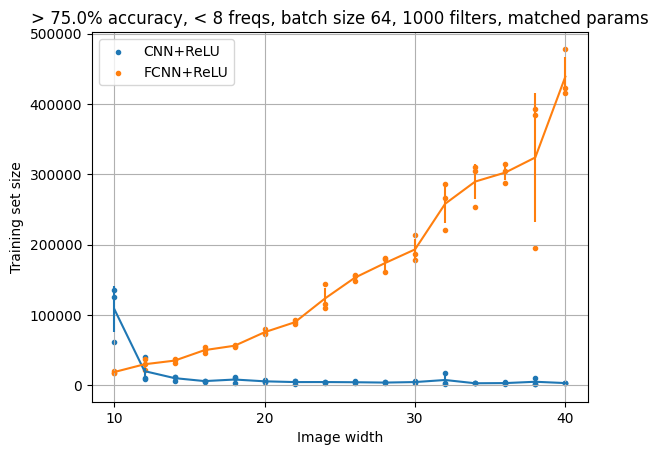

In [377]:
# Load data
with open(filepath, 'rb') as file:
    sample_complexity = pickle.load(file)
# Extract data to plot
names = set([name for name, _ in sample_complexity.keys()])

# For every model, make line plot
for i, name in enumerate(names):
    
    # Scatter results
    xs, ys = list(zip(*sorted([(int((dim)**0.5), tr_size) for (_name, dim), tr_size  in sample_complexity.items() if name == _name])))
    
    plt.scatter(np.array(xs).repeat(len(ys[0])), np.array(ys).flatten(), marker='.', linestyle='-', label=name)

    # Plot means and standard deviations
    means = [np.mean(y) for y in ys]
    errors = [np.std(y) for y in ys]
    plt.errorbar(xs, means, errors)

# Plot graphics
plt.xlabel('Image width')
plt.ylabel('Training set size')
plt.legend()
plt.xticks(ticks=[tick for tick in plt.xticks()[0]][1::2], labels=[tick for tick in plt.xticks()[1]][1::2])
plt.title(f'Adam, > {epsilon*100}% accuracy, < {freq} freqs, batch size {batch_size}, {cnn_out_chans} filters, matched params')
plt.grid(True)

# Show the plot
plt.show()